### Description des données

Your goal is to predict the total_cases label for each (`city`, `year`, `weekofyear`) in the test set. 
There are two cities, *San Juan* and *Iquitos*, with test data for each city spanning 5 and 3 years respectively.
You will make one submission that contains predictions for both cities.
The data for each city have been concatenated along with a city column indicating the source: `sj` for San Juan and `iq` for Iquitos. 
The test set is a pure future hold-out, meaning the test data are sequential and non-overlapping with any of the training data.
Throughout, missing values have been filled as `NaN`s.

#### The features in this dataset

You are provided the following set of information on a (`year`, `weekofyear`) timescale:

(Where appropriate, units are provided as a `_unit` suffix on the feature name.)

*City and date indicators*

 - `city` – City abbreviations: `sj` for San Juan and `iq` for Iquitos
 - `week_start_date` – Date given in yyyy-mm-dd format

*NOAA's GHCN daily climate data weather station measurements*

 - `station_max_temp_c` – Maximum temperature
 - `station_min_temp_c` – Minimum temperature
 - `station_avg_temp_c` – Average temperature
 - `station_precip_mm` – Total precipitation
 - `station_diur_temp_rng_c` – Diurnal temperature range
 
*PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)*

 - `precipitation_amt_mm` – Total precipitation

*NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)*

 - `reanalysis_sat_precip_amt_mm` – Total precipitation
 - `reanalysis_dew_point_temp_k` – Mean dew point temperature
 - `reanalysis_air_temp_k` – Mean air temperature
 - `reanalysis_relative_humidity_percent` – Mean relative humidity
 - `reanalysis_specific_humidity_g_per_kg` – Mean specific humidity
 - `reanalysis_precip_amt_kg_per_m2` – Total precipitation
 - `reanalysis_max_air_temp_k` – Maximum air temperature
 - `reanalysis_min_air_temp_k` – Minimum air temperature
 - `reanalysis_avg_temp_k` – Average air temperature
 - `reanalysis_tdtr_k` – Diurnal temperature range

*Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements*

 - `ndvi_se` – Pixel southeast of city centroid
 - `ndvi_sw` – Pixel southwest of city centroid
 - `ndvi_ne` – Pixel northeast of city centroid
 - `ndvi_nw` – Pixel northwest of city centroid

In [1]:
# Load pyspark
import findspark

findspark.init()

from pyspark import SparkContext

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml import Pipeline

from pyspark.sql.window import Window
from pyspark.ml.stat import Correlation

In [2]:
import pandas as pd
import numpy as np

# charting
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
spark = SparkSession.builder.appName("dengue").getOrCreate()

### Chargement des données

In [4]:
path_to_data = "data/"

df_features = spark.read.csv(path_to_data + "dengue_features_train.csv",
                             header=True)
df_labels = spark.read.csv(path_to_data + "dengue_labels_train.csv",
                           header=True)

In [5]:
df_features.printSchema()

root
 |-- city: string (nullable = true)
 |-- year: string (nullable = true)
 |-- weekofyear: string (nullable = true)
 |-- week_start_date: string (nullable = true)
 |-- ndvi_ne: string (nullable = true)
 |-- ndvi_nw: string (nullable = true)
 |-- ndvi_se: string (nullable = true)
 |-- ndvi_sw: string (nullable = true)
 |-- precipitation_amt_mm: string (nullable = true)
 |-- reanalysis_air_temp_k: string (nullable = true)
 |-- reanalysis_avg_temp_k: string (nullable = true)
 |-- reanalysis_dew_point_temp_k: string (nullable = true)
 |-- reanalysis_max_air_temp_k: string (nullable = true)
 |-- reanalysis_min_air_temp_k: string (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: string (nullable = true)
 |-- reanalysis_relative_humidity_percent: string (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: string (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: string (nullable = true)
 |-- reanalysis_tdtr_k: string (nullable = true)
 |-- station_avg_temp_c: string (nulla

In [6]:
df_labels.printSchema()

root
 |-- city: string (nullable = true)
 |-- year: string (nullable = true)
 |-- weekofyear: string (nullable = true)
 |-- total_cases: string (nullable = true)



### Jointure

Nous joignons les deux DataFrames

In [7]:
#join
df_train = df_features.join(df_labels, ['city', 'year', 'weekofyear'])

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train = (1456, 25)


### Nettoyage

In [8]:
# The 2 columns 'precipitation_amt_mm' and 'reanalysis_sat_precip_amt_mm' are the same
# we drop 'precipitation_amt_mm'
df_train = df_train.drop('precipitation_amt_mm')

# recast 'week_start_date' as a date. Nice to have for plotting or time series analysis
df_train = df_train.withColumn('week_start_date', F.to_date('week_start_date', 'yyyy-MM-dd'))

# recast 'year' and 'weekofyear' to integer
df_train = df_train \
    .withColumn('year', df_train['year'].cast('int')) \
    .withColumn('weekofyear', df_train['weekofyear'].cast('int'))

# cast column to float
for col_name in df_train.columns[4:]:
    df_train = df_train.withColumn(col_name, df_train[col_name].cast('float'))

In [9]:
print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

# identify null value
for col_name in df_train.columns:
    print("{} => {}".format(col_name,
                            df_train.filter(F.isnull(df_train[col_name])).count()))
    
df_train = df_train.dropna()

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train = (1456, 24)
city => 0
year => 0
weekofyear => 0
week_start_date => 0
ndvi_ne => 194
ndvi_nw => 52
ndvi_se => 22
ndvi_sw => 22
reanalysis_air_temp_k => 10
reanalysis_avg_temp_k => 10
reanalysis_dew_point_temp_k => 10
reanalysis_max_air_temp_k => 10
reanalysis_min_air_temp_k => 10
reanalysis_precip_amt_kg_per_m2 => 10
reanalysis_relative_humidity_percent => 10
reanalysis_sat_precip_amt_mm => 13
reanalysis_specific_humidity_g_per_kg => 10
reanalysis_tdtr_k => 10
station_avg_temp_c => 43
station_diur_temp_rng_c => 43
station_max_temp_c => 20
station_min_temp_c => 14
station_precip_mm => 22
total_cases => 0
df_train = (1199, 24)


In [10]:
df_train.printSchema()

root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- week_start_date: date (nullable = true)
 |-- ndvi_ne: float (nullable = true)
 |-- ndvi_nw: float (nullable = true)
 |-- ndvi_se: float (nullable = true)
 |-- ndvi_sw: float (nullable = true)
 |-- reanalysis_air_temp_k: float (nullable = true)
 |-- reanalysis_avg_temp_k: float (nullable = true)
 |-- reanalysis_dew_point_temp_k: float (nullable = true)
 |-- reanalysis_max_air_temp_k: float (nullable = true)
 |-- reanalysis_min_air_temp_k: float (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: float (nullable = true)
 |-- reanalysis_relative_humidity_percent: float (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: float (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: float (nullable = true)
 |-- reanalysis_tdtr_k: float (nullable = true)
 |-- station_avg_temp_c: float (nullable = true)
 |-- station_diur_temp_rng_c: float (nullable = true)
 

### Plot

In [11]:
# create pandas dataframe from spark dataframe

pd_train = df_train.toPandas()

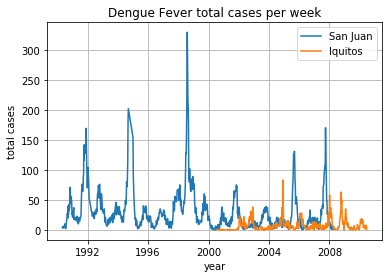

In [12]:
pd_train_sj = pd_train[pd_train['city'] == 'sj']
pd_train_iq = pd_train[pd_train['city'] == 'iq']

# Total cases per city
plt.figure()

plt.grid()
plt.title('Dengue Fever total cases per week')


plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'], label='San Juan')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'], label='Iquitos')

plt.legend()

plt.show()

### Buid a new column

In [13]:
from pyspark.sql.window import Window
from pyspark.ml.stat import Correlation

w = Window().partitionBy().orderBy(F.col('week_start_date'))
#df_train.select('week_start_date', 'station_avg_temp_c',
#                F.lag('station_avg_temp_c', count=1).over(w).alias('avg_temp_1_c'))\
#        .show()

df_train2 = df_train.withColumn('avg_temp_1_c', F.lag('station_avg_temp_c', count=1).over(w)) \
    .withColumn('avg_temp_2_c', F.lag('station_avg_temp_c', count=2).over(w)) \
    .withColumn('avg_temp_3_c', F.lag('station_avg_temp_c', count=3).over(w)) \
    .withColumn('avg_temp_4_c', F.lag('station_avg_temp_c', count=4).over(w))
#    .select('week_start_date', 'station_avg_temp_c', 'avg_temp_1_c', 'avg_temp_2_c', 'avg_temp_3_c', 'avg_temp_4_c')

#corr = Correlation.corr(df_corr, 'station_avg_temp_c')
df_train2 = df_train2.withColumn('station_precip_1_mm', F.lag('station_precip_mm', count=1).over(w)) \
    .withColumn('station_precip_2_mm', F.lag('station_precip_mm', count=2).over(w)) \
    .withColumn('station_precip_3_mm', F.lag('station_precip_mm', count=3).over(w)) \
    .withColumn('station_precip_4_mm', F.lag('station_precip_mm', count=4).over(w)) \
#    .select('week_start_date', 'station_avg_temp_c', 'avg_temp_1_c', 'avg_temp_2_c', 'avg_temp_3_c', 'avg_temp_4_c')


In [14]:
df_train2 = df_train2.dropna()

### Construction des jeux d'entrainement et de test

In [15]:
train, test = df_train2.randomSplit([0.75, 0.25], seed=18)

#train.cache()

In [ ]:
train.cache()

### Construction du *pipeline*

In [ ]:
indexer = StringIndexer(inputCol='city', outputCol='city_')

encoder = OneHotEncoder(inputCol='city_', outputCol='cityVect')

vectorAssembler = VectorAssembler(
    inputCols=['year', 'weekofyear',
               'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
               'reanalysis_air_temp_k','reanalysis_avg_temp_k',
               'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
               'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
               'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
               'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
               'station_avg_temp_c',
#               'avg_temp_1_c', 'avg_temp_2_c', 'avg_temp_3_c', 'avg_temp_4_c',
               'station_diur_temp_rng_c',
               'station_max_temp_c', 'station_min_temp_c', 
               'station_precip_mm',
#               'station_precip_1_mm', 'station_precip_2_mm', 'station_precip_3_mm', 'station_precip_4_mm',
               'cityVect'], 
    outputCol = 'features')

scaler = StandardScaler(inputCol='features',
                        outputCol="scaled_features",
                        withStd=True, withMean=True)

lr = LinearRegression(featuresCol='scaled_features',
                      labelCol='total_cases',
                      predictionCol='lr_prediction')

rf = RandomForestRegressor(featuresCol='scaled_features',
                           labelCol='total_cases',
                           predictionCol='rf_prediction')

#### 1. Random Forest

In [ ]:
pipeline_rf = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler, rf])

evaluator_rf = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   metricName="rmse")

In [ ]:
# build model

model_rf = pipeline_rf.fit(train)

In [ ]:
# Build prediction from 'test' dataset
pred_rf = model_rf.transform(test)

In [ ]:
pred_rf.select(['total_cases','rf_prediction']).show(150)

In [ ]:
rmse = evaluator_rf.evaluate(pred_rf)

print("Random Forest::Before grid search - RMSE = {:.3f}".format(rmse))

#### Cross-Validation

In [ ]:
# Parameter grid for random forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 5, 10, 15, 20]) \
    .addGrid(rf.numTrees, [10, 20, 30, 40, 50]) \
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator_rf,
                             numFolds=2,
                             seed=18)

In [ ]:
cv_model_rf = crossval_rf.fit(train)

In [ ]:
# Build prediction from 'test' dataset
cv_pred_rf = cv_model_rf.transform(test)

In [ ]:
rmse = evaluator_rf.evaluate(cv_pred_rf)

print("Random Forest::After grid search - RMSE = {:.3f}".format(rmse))

In [ ]:
cv_model_rf.bestModel.stages[-1].getNumTrees

#### plot

In [ ]:
# create pandas dataframe from spark dataframe
pd_pred_rf = cv_pred_rf.toPandas()

pd_pred_rf_sj = pd_pred_rf[pd_pred_rf['city'] == 'sj']
pd_pred_rf_iq = pd_pred_rf[pd_pred_rf['city'] == 'iq']

In [ ]:
# Total cases per city
plt.figure()

plt.grid()
plt.title('Random Forest: Prediction Dengue Fever total cases per week')


plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'], label='San Juan')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'], label='Iquitos')

plt.plot(pd_pred_rf_sj['week_start_date'], pd_pred_rf_sj['total_cases'], label='Pred: San Juan')
plt.plot(pd_pred_rf_iq['week_start_date'], pd_pred_rf_iq['total_cases'], label='Pred: Iquitos')

plt.legend()

plt.show()

#### 2. Linear regression

In [ ]:
pipeline_lr = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler, lr])

evaluator_lr = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='lr_prediction',
                                   metricName="rmse")

In [ ]:
model_lr = pipeline_lr.fit(train)

In [ ]:
# Build prediction from 'test' dataset
pred_lr = model_lr.transform(test)

In [ ]:
pred_lr.select(['total_cases','lr_prediction']).show(10)

In [ ]:
rmse = evaluator_lr.evaluate(pred_lr)

print("Linear regression::Before grid search - RMSE = {:.3f}".format(rmse))

#### Cross-Validation

In [ ]:
# Parameter grid for linear regression (LR)
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

crossval_lr = CrossValidator(estimator=pipeline_lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=evaluator_lr,
                             numFolds=2,
                             seed=18)

In [ ]:
cv_model_lr = crossval_lr.fit(train)

In [ ]:
# Build prediction from 'test' dataset
cv_pred_lr = cv_model_lr.transform(test)

In [ ]:
rmse = evaluator_lr.evaluate(cv_pred_lr)

print("Linear regression::After grid search - RMSE = {:.3f}".format(rmse))